In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer



In [23]:
scored_test_data = pd.read_csv('scored_test_data.csv', index_col=0)
scored_train_data = pd.read_csv('scored_train_data.csv', index_col=0)

In [24]:
scored_test_data = scored_test_data.dropna()
scored_train_data = scored_train_data.dropna()

## Dummy variables

In [25]:
vectorizer_category = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
vectorizer_badge = CountVectorizer(token_pattern=r"(?u)\b\w+\b")

#token_category_test = pd.DataFrame(vectorizer_category.fit_transform(scored_test_data['Category']).toarray())

dummies_category_test = pd.get_dummies(scored_test_data['Category'])
dummies_badges_test = scored_test_data['Badges'].str.strip('{}').str.replace('"', '').str.get_dummies(',')

dummies_category_train = pd.get_dummies(scored_train_data['Category'])
dummies_badges_train = scored_train_data['Badges'].str.strip('{}').str.replace('"', '').str.get_dummies(',')

In [26]:
token_category_test

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174792,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
174793,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174794,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0


In [27]:
dropped_cols_test = scored_test_data.drop(['Category','Badges'], axis = 1)

dropped_cols_train = scored_train_data.drop(['Category','Badges'], axis = 1)

In [28]:
complete_test_data = pd.concat([dropped_cols_test,dummies_badges_test, dummies_category_test], axis = 1)

complete_train_data = pd.concat([dropped_cols_train,dummies_badges_train, dummies_category_train], axis = 1)

In [29]:
col_interactions_test = complete_test_data.pop('interaction')
col_interactions_train = complete_train_data.pop('interaction')


complete_test_data.insert(len(complete_test_data.columns), 'interaction', col_interactions_test)
complete_train_data.insert(len(complete_train_data.columns), 'interaction', col_interactions_train)

In [30]:
complete_test_data.to_csv('scored_test_data_wth_dummies.csv')
complete_train_data.to_csv('scored_train_data_wth_dummies.csv')

# Distribution

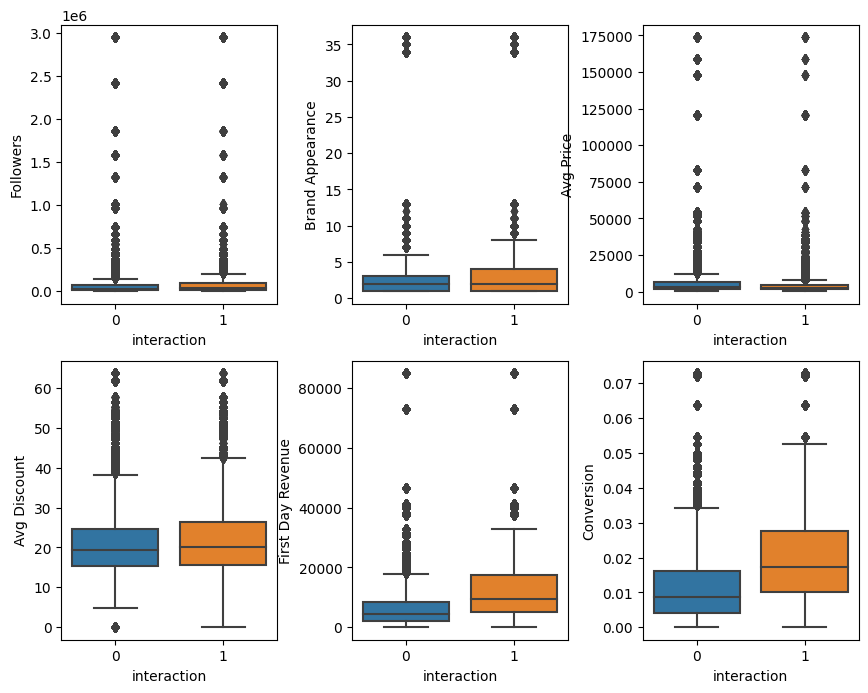

In [31]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(9,7))
fig.tight_layout(pad=2)

for i, col in enumerate(dropped_cols_train.columns[3:-4]):
    sns.boxplot(y = col, x = "interaction",data=dropped_cols_train, orient='v', ax=axes[int(i/3),i%3])

## Distribution

In [32]:
target = 'interaction'

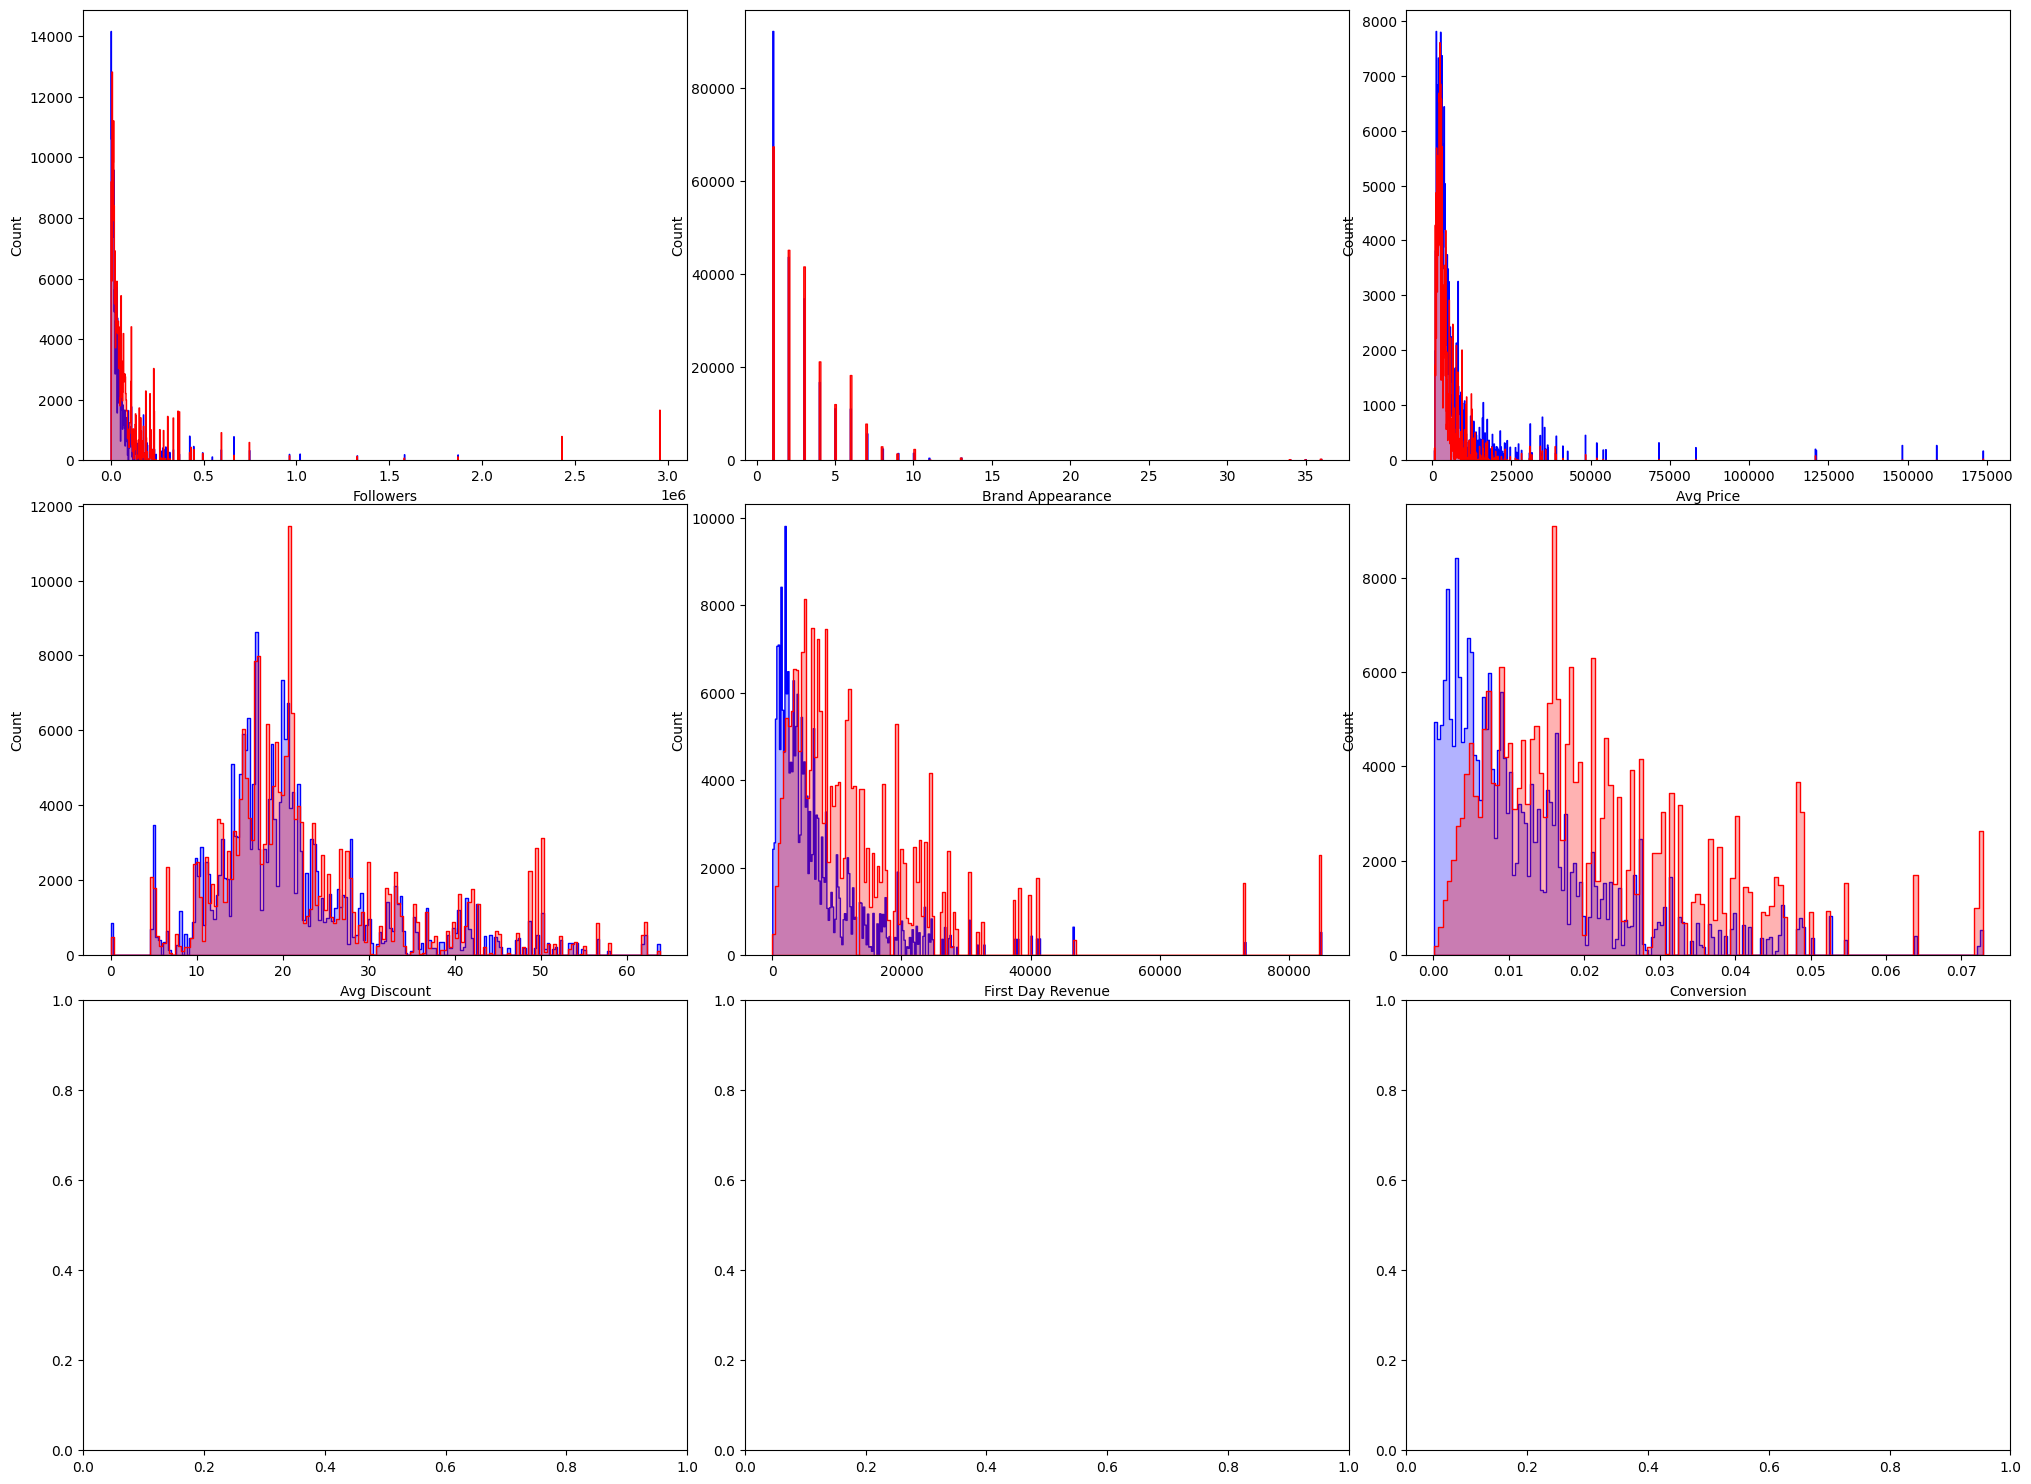

In [33]:
X= complete_train_data

X0 = X[X[target]==0]
X1 = X[X[target]==1]

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20,15))
fig.tight_layout()

for i, ax in zip(range(3,9), axes.flat):
    sns.histplot((X0.iloc[:,i]), color="blue", element="step", ax=ax,  alpha=0.3) #alpha is transparency!
    sns.histplot((X1.iloc[:,i]), color="red", element="step", ax=ax,  alpha=0.3)
plt.show()

## Transformation de décrément logarithmique

In [34]:
def adding_log(train: pd.DataFrame, columns_to_log: list):
    """ 
    Adding columns using log of provided information.
    """
    new_train = train.__deepcopy__()
    for column_name in columns_to_log:
        new_position = train.columns.get_loc(str(column_name)) + 1
        new_name = str ('log_' + str(column_name))
        new_train.insert(new_position, new_name, np.log(new_train[str(column_name)] + 1))
        new_train = new_train.drop(str(column_name), axis='columns')
        
    return (new_train)
    

In [35]:
log_columns = ['Followers', 'Avg Price', 'First Day Revenue', 'Brand Appearance']
post_prep_train_data = adding_log(complete_train_data, log_columns)
post_prep_test_data = adding_log(complete_test_data, log_columns)

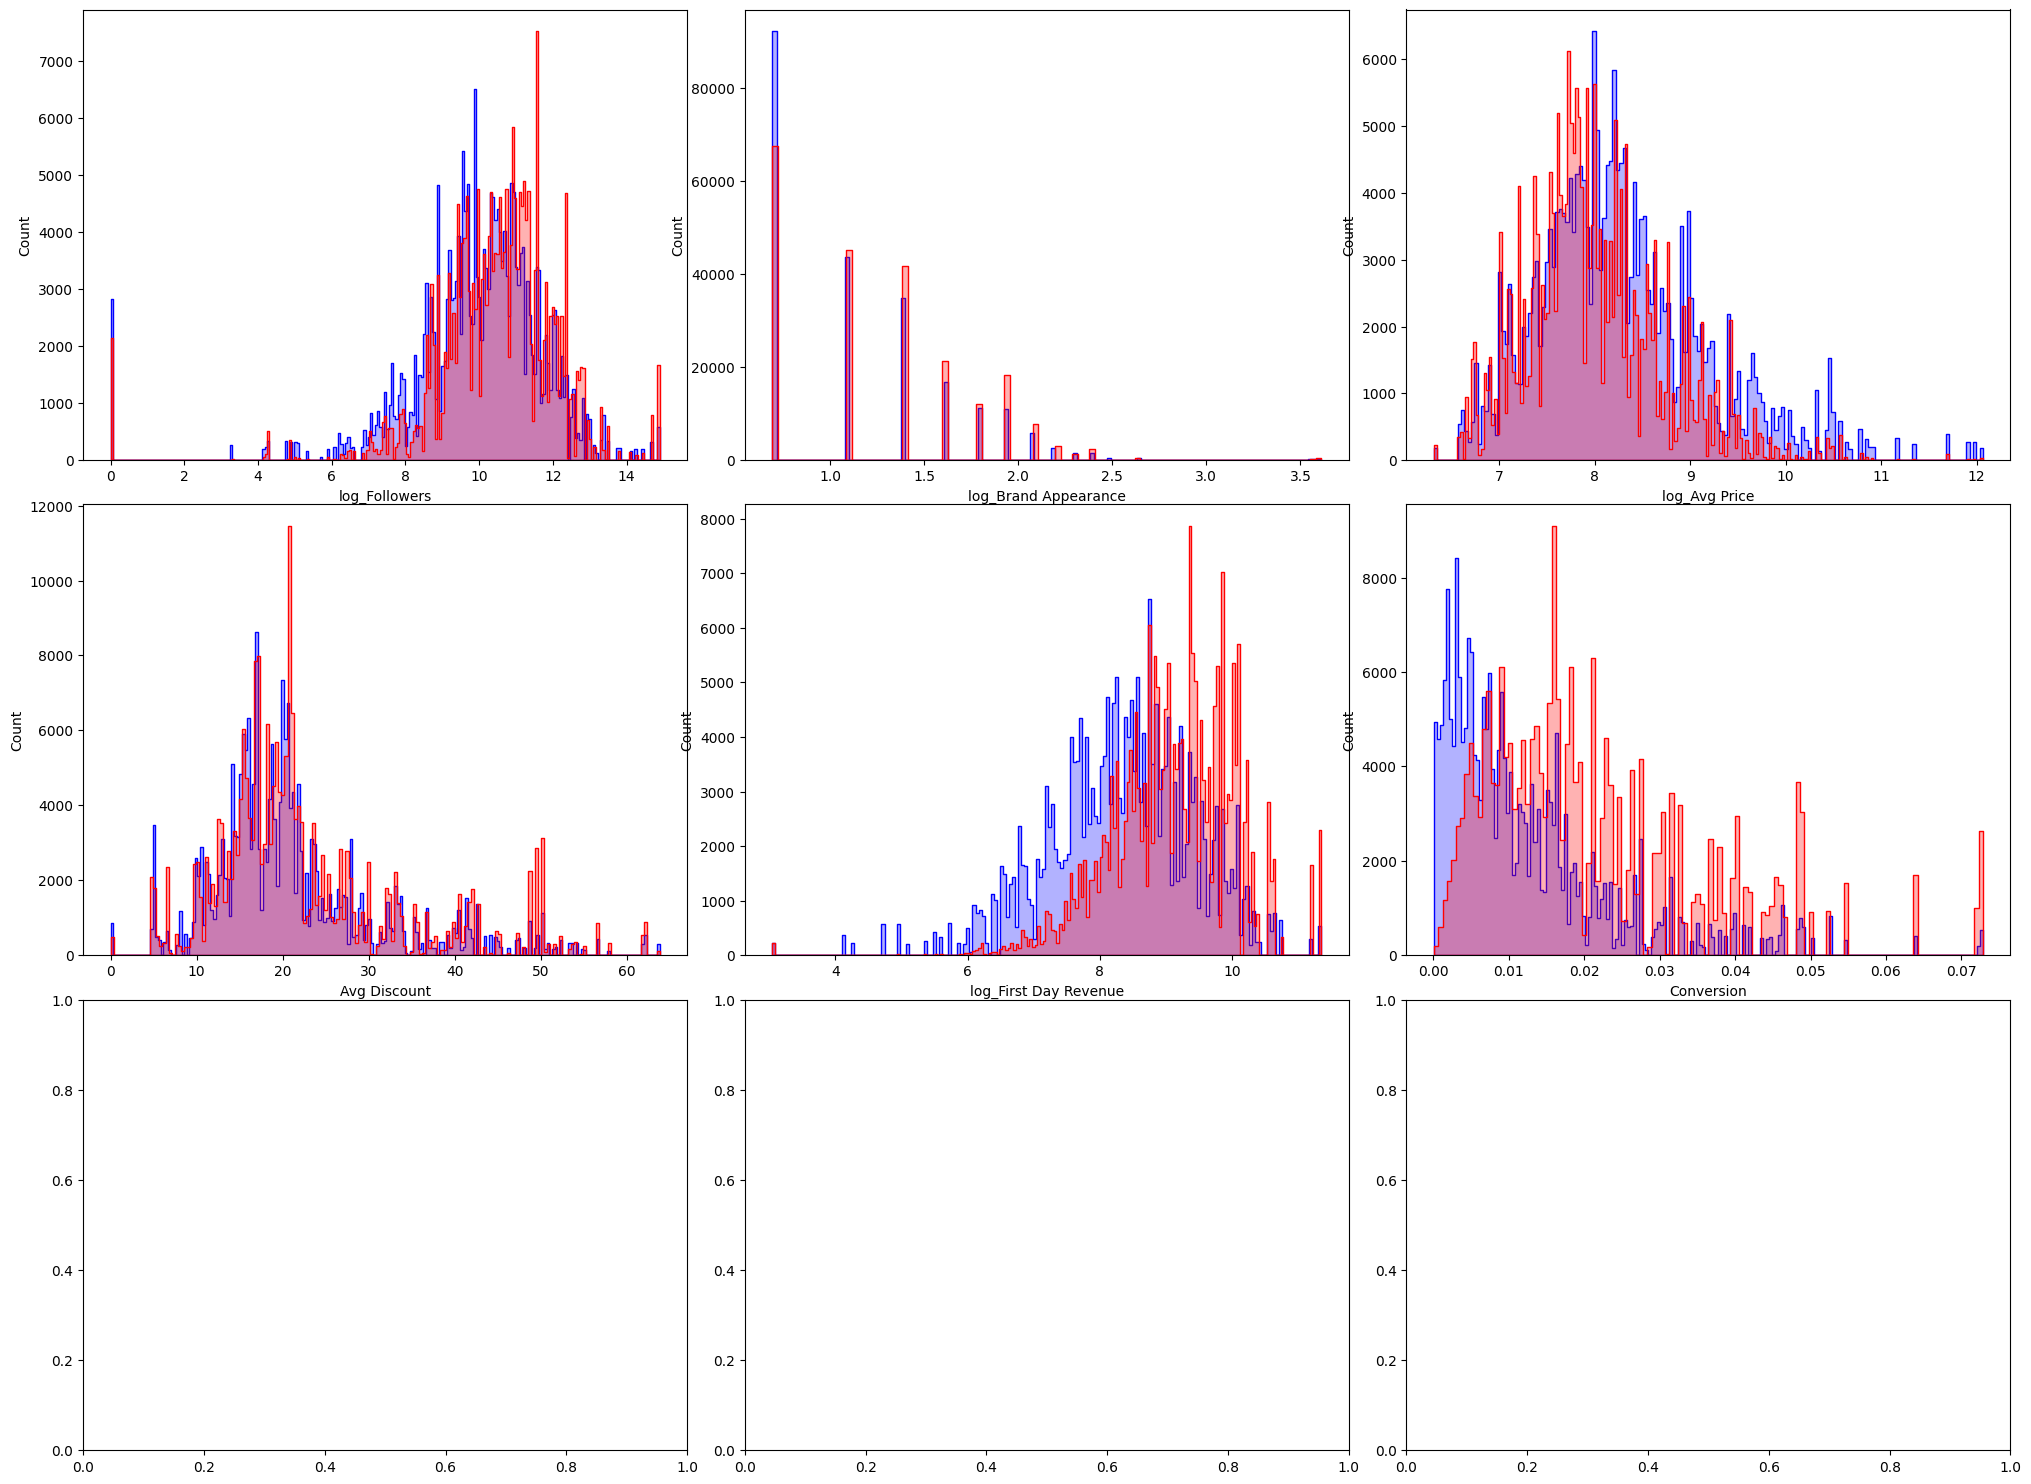

In [36]:
X= post_prep_train_data

X0 = X[X[target]==0]
X1 = X[X[target]==1]

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20,15))
fig.tight_layout()

for i, ax in zip(range(3,9), axes.flat):
    sns.histplot((X0.iloc[:,i]), color="blue", element="step", ax=ax,  alpha=0.3) #alpha is transparency!
    sns.histplot((X1.iloc[:,i]), color="red", element="step", ax=ax,  alpha=0.3)
plt.show()

## Scalling

In [37]:
def scale(train: pd.DataFrame, test: pd.DataFrame, numerical_columns: list):
    """
    Returns dataframe with the given columns scaled.
    """
    new_train = train.__deepcopy__()
    new_test = test.__deepcopy__()

    num_train_data = new_train[numerical_columns]
    num_test_data = new_test[numerical_columns]

    scaler = StandardScaler()
    scaler.fit(num_train_data)

    new_train[numerical_columns] = scaler.transform(num_train_data)
    new_test[numerical_columns] = scaler.transform(num_test_data)
    
    pickle.dump(scaler, open('scaler_numerical.sav', 'wb'))

    return (new_train, new_test)



In [38]:
num_columns = ['log_Followers',
               'log_Avg Price',
               'log_First Day Revenue',
               'log_Brand Appearance',
               'Avg Discount',
               'Conversion']
scaled_train_data, scaled_test_data = scale(post_prep_train_data,
                                            post_prep_test_data,
                                            num_columns)

In [39]:
np.where(np.isinf(post_prep_train_data[num_columns]))

(array([], dtype=int64), array([], dtype=int64))

<Axes: >

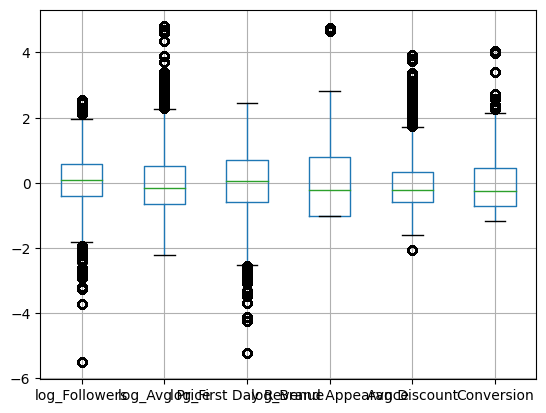

In [40]:
scaled_train_data[num_columns].boxplot()

In [41]:
scaled_train_data.to_csv('preped_test_data_wth_dummies.csv')
scaled_test_data.to_csv('preped_train_data_wth_dummies.csv')

In [42]:
scored_test_data.groupby('User Key').count()

,Sale ID,Start At,Followers,Brand Appearance,Avg Price,Avg Discount,First Day Revenue,Category,Badges,Conversion,Recency,Frequency,Monetary,interaction
User Key,,,,,,,,,,,,,,
00036SsVCBaEYTtyO0CppxHLbZw2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
008hOZ6DmLQGyMf7W2yOP1skFSw1,4,4,4,4,4,4,4,4,4,4,4,4,4,4
00EgukEbzlPiX7BaAJHgXp92CqG3,2,2,2,2,2,2,2,2,2,2,2,2,2,2
00YdcE3QEDcBGLW9HFmwaPXOjNw1,2,2,2,2,2,2,2,2,2,2,2,2,2,2
00gWmYC2S3YFEQ9jYRTUyXUx1132,2,2,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzPTgtIXzFTigp7gNRDXQ49Cl7i2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
zzSlusermJRt7cMDuVrmT99YndD2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
zzWUNSYQ2CWwopiILtUU4kaBEm13,5,5,5,5,5,5,5,5,5,5,5,5,5,5


In [55]:
score_train_data = pd.read_csv('preped_train_data_wth_dummies.csv', index_col=0)
X_train = score_train_data.iloc[:, 3:len(score_train_data.columns)-1]
Y_train = score_train_data.iloc[:, len(score_train_data.columns)-1:]
# Y_train = np.ravel(Y_train)

In [56]:
from sklearn.linear_model import LinearRegression #Ordinary Least Squares
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)

LinearRegression()

In [61]:
regr.predict(X_train)

array([[0.54427569],
       [0.67027584],
       [0.4529692 ],
       ...,
       [0.47288477],
       [0.32650946],
       [0.1904154 ]])

In [57]:
import pickle
pickle.dump(regr, open('reg_model.pkl', 'wb'))

In [58]:
X_train.shape

(174796, 57)